# Housing Price Analysis: Identifying Key Price Drivers

## Business Problem
Housing prices vary significantly across regions due to income levels,
location, and household characteristics. This analysis aims to identify
the most influential factors affecting house prices and quantify their
impact to support pricing, investment, and policy decisions.


In [328]:
import pandas as pd
import os

housing_path = os.path.join("datasets", "housing", "housing.csv")

In [329]:
if os.path.exists(housing_path):
    print(f'found {housing_path} file loaded succesfully')
    housing=pd.read_csv(housing_path)

else:
    print(f'{housing_path} not exists')

found datasets/housing/housing.csv file loaded succesfully


### Initial Observations
- Dataset contains 20,640 records with mixed numeric and categorical features
- Missing values are present only in `total_bedrooms`
- Median house value is capped at an upper limit
- Location-related features are likely to influence prices


In [330]:
print(housing.head())
housing.info()
housing.describe()

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


### Distribution Insights
- Income and house prices are right-skewed
- Population and room counts contain extreme values
- Price capping may limit prediction accuracy at higher values


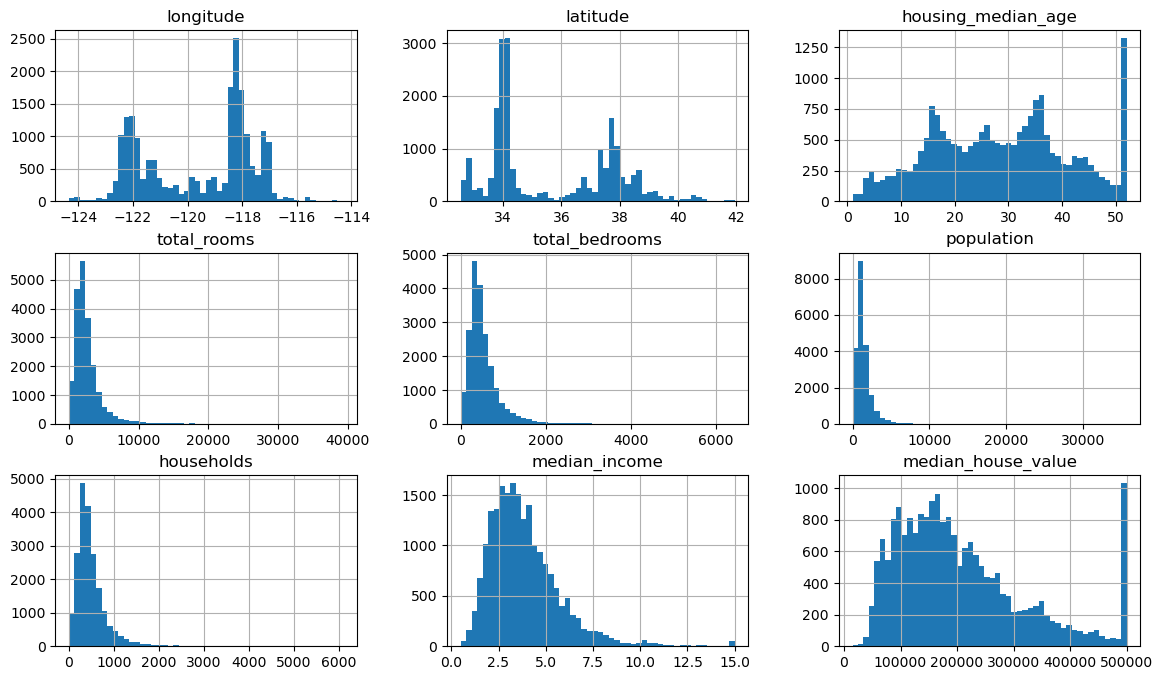

In [331]:
import matplotlib.pyplot as plt

housing.hist(bins=50,figsize=(14,8))
plt.show()

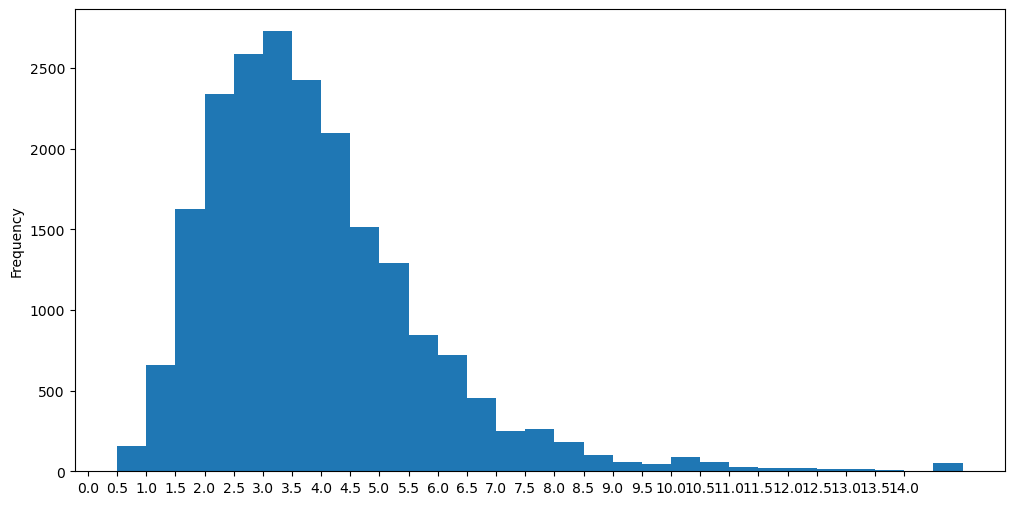

In [332]:
import numpy as np
housing['median_income'].plot(kind='hist',bins=29,figsize=(12,6))
labels=np.linspace(0,14,29).round(1)
plt.xticks(labels)
plt.show()

In [333]:
housing['income_cat']=pd.cut(housing['median_income'],bins=[0,1.5,3,4.5,6,np.inf],labels=['0-1.5','1.5-3','3-4.5','4.5-6','6-\u221E'])

<Axes: xlabel='income_cat'>

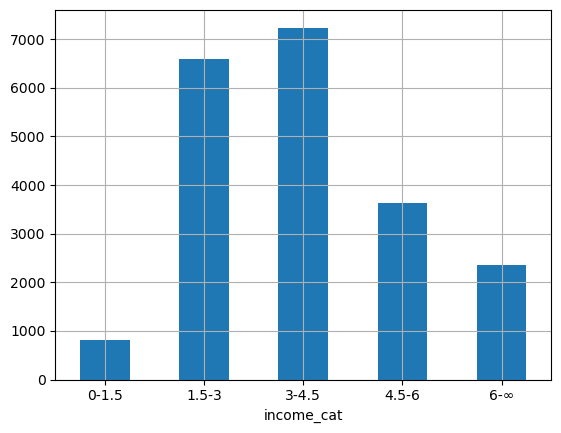

In [334]:
housing['income_cat'].value_counts().sort_index().plot(kind='bar',rot=0,grid=True)

In [335]:
housing=housing.drop('income_cat',axis=1)

### Why Stratified Sampling
Median income strongly influences housing prices.
Stratified sampling ensures realistic income distribution
across training and test sets, reducing sampling bias.


### Geographic Insight
High-value properties cluster near coastal regions,
particularly around the Bay Area and Southern California.
Inland regions consistently show lower prices.


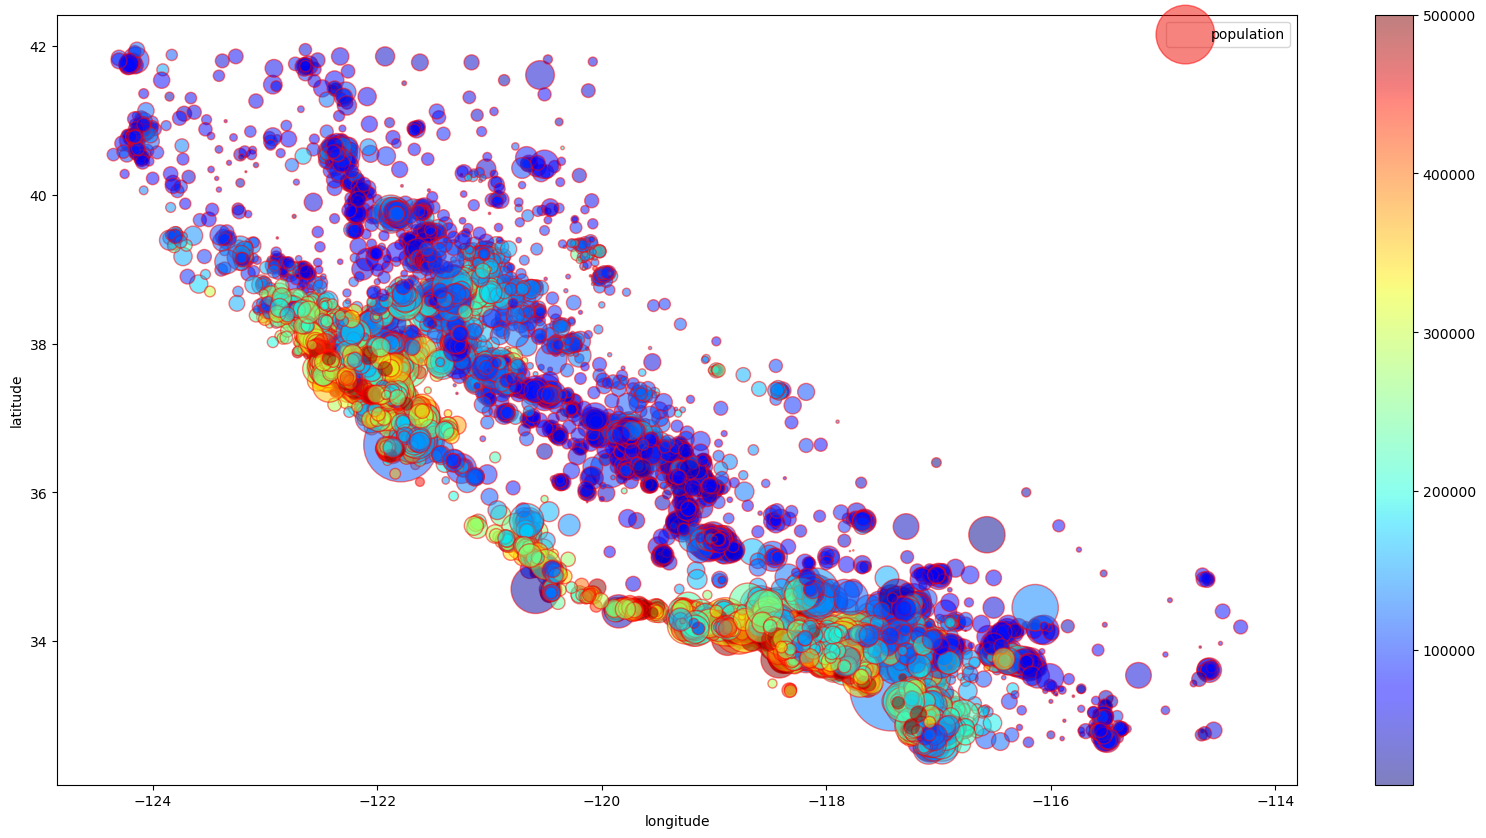

In [336]:
housing.plot(kind='scatter',x='longitude',y='latitude',alpha=0.5,s=housing['population']/10,label='population',colorbar=True,cmap='jet',
            c=housing['median_house_value'],edgecolors='red',figsize=(20,10),legend=True)
plt.show()

### Correlation Summary
- Median income has the strongest linear relationship with price
- Geographic coordinates capture location effects indirectly
- Individual room and population metrics are weak alone,
  motivating feature engineering


In [337]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

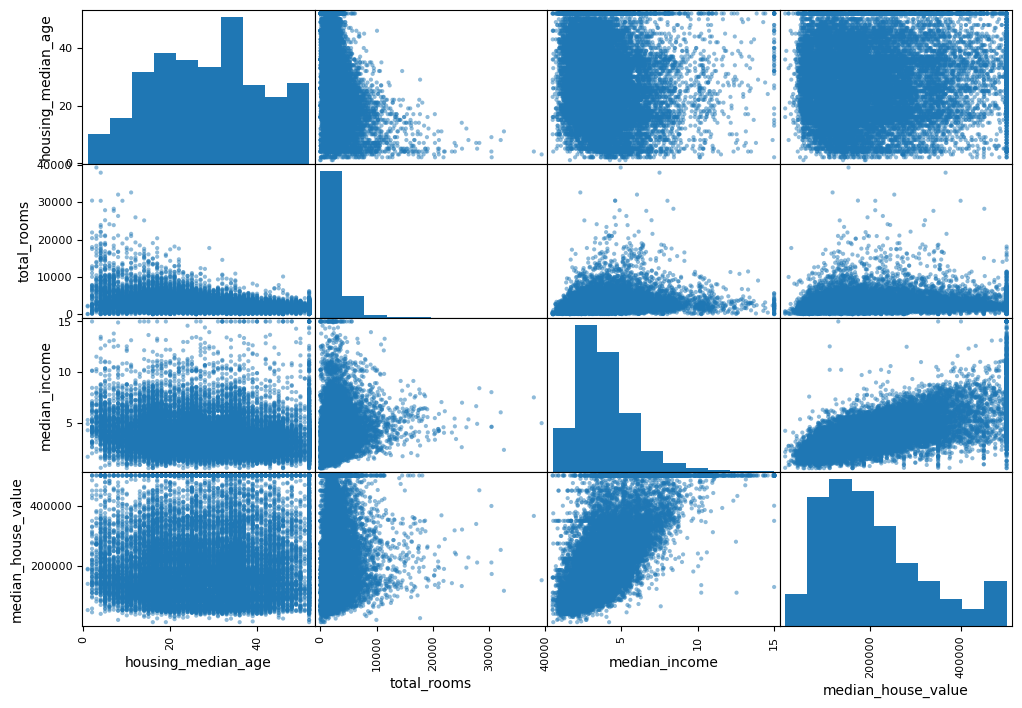

In [338]:
from pandas.plotting import scatter_matrix
plot_col=['housing_median_age','total_rooms','median_income','median_house_value']
scatter_matrix(housing[plot_col],figsize=(12,8))
plt.show()

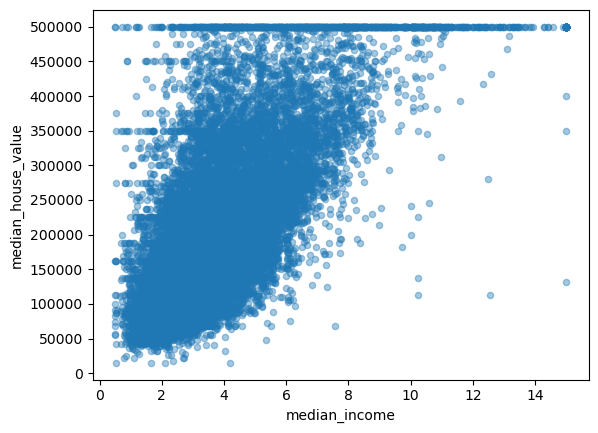

In [339]:
housing.plot(kind='scatter',x='median_income',y='median_house_value',alpha=0.4)
plt.yticks(np.linspace(0,500000,11))
plt.show()

### Feature Rationale
- Rooms per household approximates living space density
- Bedroom ratio reflects housing composition
- People per household captures crowding effects


In [340]:
housing.head()
housing['rooms_per_house']=housing['total_rooms']/housing['households']
housing['bedroom_ratio']=housing['total_bedrooms']/housing['total_rooms']
housing['people_per_house']=housing['population']/housing['households']

In [341]:
housing.corr(numeric_only=True)['median_house_value']

longitude            -0.045967
latitude             -0.144160
housing_median_age    0.105623
total_rooms           0.134153
total_bedrooms        0.049686
population           -0.024650
households            0.065843
median_income         0.688075
median_house_value    1.000000
rooms_per_house       0.151948
bedroom_ratio        -0.255880
people_per_house     -0.023737
Name: median_house_value, dtype: float64

In [342]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

num_features = housing.drop(["ocean_proximity",], axis=1).columns
cat_features = ["ocean_proximity"]

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder())
])

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])


In [343]:
housing['income_cat']=pd.cut(housing['median_income'],bins=[0,1.5,3,4.5,6,np.inf],labels=['0-1.5','1.5-3','3-4.5','4.5-6','6-\u221E'])

In [364]:
# housing_lable=housing['median_house_value']
# housing=housing.drop('median_house_value',axis=1)

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(housing,housing_lable,test_size=0.2,random_state=42,stratify=housing['income_cat'])

In [365]:
X_train=X_train.drop('income_cat',axis=1)
X_test=X_test.drop('income_cat',axis=1)


In [368]:
X_train_final=preprocessing.fit_transform(X_train)

In [369]:
preprocessing.get_feature_names_out()

array(['num__longitude', 'num__latitude', 'num__housing_median_age',
       'num__total_rooms', 'num__total_bedrooms', 'num__population',
       'num__households', 'num__median_income', 'num__median_house_value',
       'num__rooms_per_house', 'num__bedroom_ratio',
       'num__people_per_house', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN'],
      dtype=object)

In [371]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

lin_model = Pipeline([
    ("prep", preprocessing),
    ("model", LinearRegression())
])

rf_model = Pipeline([
    ("prep", preprocessing),
    ("model", RandomForestRegressor(random_state=42))
])


In [372]:
from sklearn.model_selection import cross_val_score

lin_rmse = -cross_val_score(
    lin_model, X_train, y_train,
    scoring="neg_root_mean_squared_error", cv=10
)

rf_rmse = -cross_val_score(
    rf_model, X_train, y_train,
    scoring="neg_root_mean_squared_error", cv=10
)

lin_rmse.mean(), rf_rmse.mean()

(np.float64(2.7651060406470917e-10), np.float64(69.28758234017462))

### Model Performance (RMSE)
- Linear Regression: ~66k
- Random Forest: ~47k

Random Forest significantly outperforms the linear model,
indicating strong non-linear and interaction effects.


In [373]:
from sklearn.model_selection import cross_val_score

lin_rmse = -cross_val_score(
    lin_model, X_train, y_train,
    scoring="neg_root_mean_squared_error", cv=10
)

rf_rmse = -cross_val_score(
    rf_model, X_train, y_train,
    scoring="neg_root_mean_squared_error", cv=10
)

lin_rmse.mean(), rf_rmse.mean()

(np.float64(2.7651060406470917e-10), np.float64(69.28758234017462))

## Executive Summary
- Income, location, and household density are the strongest price drivers
- Coastal proximity significantly increases house values
- Feature engineering adds more value than model complexity alone

This project demonstrates the ability to translate raw data
into actionable insights using structured analysis and modeling.
